<font size="5"><center> <b>Sandpyper: sandy beaches SfM-UAV analysis tools</b></center></font>
<font size="4"><center> <b> Example 1 - Profiles extraction </b></center> <br>

    
<center><img src="images/banner.png" width="80%"  /></center>

<font face="Calibri">
<br>
<font size="5"> <b>Profiles creation and data extraction from DSM and orthophotos</b></font>

<br>
<font size="4"> <b> Nicolas Pucino; PhD Student @ Deakin University, Australia </b> <br>

<font size="3">The first steps in a typical workflow is to create cross-shore transects in all the locations and extract elevation and RGB information along those transects. Sandpiper allows the data extraction from hundreds of rasters at once, in an organised way. <br>

<b>This notebook covers the following concepts:</b>

- Naming conventions and global parameters.
- Setting up the folders.
- Setting up the folders.
</font>


</font>

Import all it is required.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

from sandpyper.outils import cross_ref
from sandpyper.profile import extract_from_folder
from sandpyper.space import create_transects

pd.options.mode.chained_assignment = None  # default='warn'

C:\conda3\envs\sandpyper_env\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
class ProfileSet():
    """
    ciao
    """
    def __init__(self,
                 dirNameDSM=None,
                 dirNameOrtho=None,
                 dirNameTrans=None,
                 loc_codes=None,
                 loc_search_dict=None,
                 crs_dict_string=None,
                check="dsm"):
        
        if check=="dsm":
            path_in=self.dirNameDSM
        elif check == "ortho":
            path_in=self.dirNameOrtho
        elif check == "all":
            path_in=[self.dirNameDSM, self.dirNameOrtho]
        
        
        self.dirNameDSM=dirNameDSM
        self.dirNameOrtho=dirNameOrtho
        self.dirNameTrans=dirNameTrans
        
        self.loc_codes=loc_codes
        self.loc_search_dict=loc_search_dict
        self.crs_dict_string=crs_dict_string
        
        self.check=cross_ref(path_in,
                        self.dirNameTrans,
                        print_info=True, 
                        loc_search_dict=self.loc_search_dict,
                        list_loc_codes=self.loc_codes)

        
    def extract_profiles(self,
                         mode,
                         sampling_step,
                         add_xy,
                         add_slope=False,
                         default_nan_values=-10000):
        
        if mode=="dsm":
            path_in=self.dirNameDSM
        elif mode == "ortho":
            path_in=self.dirNameOrtho
        else:
            raise NameError("mode must be either 'dsm' or 'rgb'.")
        
        profiles=extract_from_folder(dataset_folder=path_in,
                        transect_folder=self.dirNameTrans,
                        mode=mode,sampling_step=sampling_step,
                        list_loc_codes=self.loc_codes,
                        add_xy=True)
        if mode=="dsm":
            self.profiles_z=profiles
        else:
            self.profiles_rgb=profiles
        
        self.sampling_step=sampling_step


In [3]:
from sandpyper.outils import extract_loc_date,getCrs_from_raster_path,getCrs_from_transect,getLoc
def filepath_raster_type(ras_path):
        """Returns 'dsm' if ras_path is of a DSM (1 single band) or 'ortho' if has multiple bands."""
        with ras.open(r"{}".format(ras_path)) as raster:
            if raster.count==1:
                return "dsm"
            else:
                return "ortho"

In [13]:
import rasterio as ras

In [57]:
def cross_ref(
    dir_inputs, dirNameTrans, loc_search_dict, list_loc_codes, print_info=False
):
    """
    Returns a dataframe with location, raw_date, filenames (paths)
    and CRS of each raster and associated transect files. Used to double-check.

    Args:
        dirNameDSM (str): Path of the directory containing the geotiffs datasets (.tiff or .tif).
        dirNameTrans (str): Path of the directory containing the transects (geopackages, .gpkg).
        loc_search_dict (list): Dictionary used to match filename with right location code.
        list_loc_codes (list): list of strings containing location codes.
        print_info (bool): If True, prints count of datasets/location and total. Default = False.

    Returns:
        Dataframe and information about raster-transect files matches.
    """

    # DF transects
    list_transects = glob.glob(f"{dirNameTrans}\*.gpkg")
    locs_transects = pd.DataFrame(
        pd.Series(
            [getLoc(trs, list_loc_codes) for trs in list_transects], name="location"
        )
    )
    
    df_tmp_trd = pd.DataFrame(locs_transects, columns=["location"])
    df_tmp_trd["filename_trs"] = list_transects
    df_tmp_trd["crs_transect"] = df_tmp_trd.filename_trs.apply(getCrs_from_transect)
        
    if isinstance(dir_inputs, list):
        dirs=dir_inputs
    else:
        dirs=[dir_inputs]
        
    rasters_df=pd.DataFrame()
    
    for path_in in dirs:

        list_rasters = glob.glob(f"{path_in}\*.ti*")
        loc_date_labels_raster = [
            extract_loc_date(file1, loc_search_dict=loc_search_dict)
            for file1 in list_rasters
        ]

        df_tmp_raster = pd.DataFrame(
            loc_date_labels_raster, columns=["location", "raw_date"]
        )
        df_tmp_raster["filename_raster"] = list_rasters
        df_tmp_raster["crs_raster"] = df_tmp_raster.filename_raster.apply(
            getCrs_from_raster_path
        )
        df_tmp_raster["raster_type"]=[filepath_raster_type(i) for i in list_rasters]
        
        rasters_df=pd.concat([rasters_df,df_tmp_raster], ignore_index=True)

    matched = pd.merge(rasters_df, df_tmp_trd, on="location", how="left").set_index(
        ["location"]
    )

    if bool(print_info) is True:
        counts=check.groupby(["location","raster_type"]).count().reset_index()

        for i,row in counts.iterrows():
            print(f"{row['raster_type']} from {row['location']} = {row['raw_date']}\n")

        print(f"\nNUMBER OF DATASETS TO PROCESS: {counts.raw_date.sum()}")

    return matched

In [58]:
check=cross_ref([dirNameDSM,dirNameOrtho],dirNameTrans,print_info=True, loc_search_dict=loc_search_dict,list_loc_codes=loc_codes)
check

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


dsm from leo = 6

ortho from leo = 6

dsm from mar = 9

ortho from mar = 9


NUMBER OF DATASETS TO PROCESS: 30


,raw_date,filename_raster,crs_raster,raster_type,filename_trs,crs_transect
location,,,,,,
leo,20180606,C:\my_packages\sandpyper\tests\test_data\dsm_1...,32755,dsm,C:\my_packages\sandpyper\tests\test_data\trans...,epsg:32755
leo,20180713,C:\my_packages\sandpyper\tests\test_data\dsm_1...,32755,dsm,C:\my_packages\sandpyper\tests\test_data\trans...,epsg:32755
leo,20180920,C:\my_packages\sandpyper\tests\test_data\dsm_1...,32755,dsm,C:\my_packages\sandpyper\tests\test_data\trans...,epsg:32755
leo,20190211,C:\my_packages\sandpyper\tests\test_data\dsm_1...,32755,dsm,C:\my_packages\sandpyper\tests\test_data\trans...,epsg:32755
leo,20190328,C:\my_packages\sandpyper\tests\test_data\dsm_1...,32755,dsm,C:\my_packages\sandpyper\tests\test_data\trans...,epsg:32755
leo,20190731,C:\my_packages\sandpyper\tests\test_data\dsm_1...,32755,dsm,C:\my_packages\sandpyper\tests\test_data\trans...,epsg:32755
mar,20180601,C:\my_packages\sandpyper\tests\test_data\dsm_1...,32754,dsm,C:\my_packages\sandpyper\tests\test_data\trans...,epsg:32754
mar,20180621,C:\my_packages\sandpyper\tests\test_data\dsm_1...,32754,dsm,C:\my_packages\sandpyper\tests\test_data\trans...,epsg:32754
mar,20180727,C:\my_packages\sandpyper\tests\test_data\dsm_1...,32754,dsm,C:\my_packages\sandpyper\tests\test_data\trans...,epsg:32754


In [51]:
counts=check.groupby(["location","raster_type"]).count().reset_index()

for i,row in counts.iterrows():
    print(f"{row['raster_type']} from {row['location']} = {row['raw_date']}\n")
    
print(f"\nNUMBER OF DATASETS TO PROCESS: {counts.raw_date.sum()}")

dsm from leo = 6

ortho from leo = 6

dsm from mar = 9

ortho from mar = 9



In [6]:
dirNameDSM=r'C:\my_packages\sandpyper\tests\test_data\dsm_1m'

dirNameOrtho=r'C:\my_packages\sandpyper\tests\test_data\orthos_1m'

dirNameTrans=r'C:\my_packages\sandpyper\tests\test_data\transects'

In [78]:
P=ProfileSet(dirNameDSM,
            dirNameOrtho,
            dirNameTrans,
            loc_codes,
            loc_search_dict,
            crs_dict_string)

RasterioIOError: C:/my_packages/sandpyper/tests/test_data/dsm_1m: Permission denied

In [35]:
P.extract_profiles('dsm',10,True)

  0%|          | 0/15 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Extraction succesfull
Number of points extracted:3318
Time for processing=18.865577936172485 seconds
First 10 rows are printed below
Number of points outside the raster extents: 912
The extraction assigns NaN.
Number of points in NoData areas within the raster extents: 32
The extraction assigns NaN.


<AxesSubplot:>

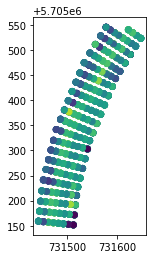

In [28]:
P.profiles_rgb.query("location=='mar'").plot(column="z")

## Global parameters
### Location codes
When your analysis involves a multi-site approach, it is convenient to assign each location a __small code__ to easy the handling of every associated file and its coordinate reference system.

Here are some examples:
* Saint Leonards : __leo__
* Marengo : __mar__

In [7]:
# The location codes used troughout the analysis
loc_codes=["mar","leo"]

### Location search dictionary
Sometimes, we need to automatically obtain the right location code from raster files, either of Digital Surface Models (DSM) or Orthophotos (ORTO), whose filenames contains the original location name (e.g. Saint_Leonards or Warrnambool).

An easy and fast way to do this, is to create a dictionary, where __keys are the location codes__ and the __values are lists of possible full names__ we expect to find in the files.
Here are some examples:

```python
loc_search_dict = {   'leo': ['St','Leonards','leonards','leo'],
                      'mar': ['Marengo','marengo','mar'] }
```
> __NOTE__: always include the location codes in the list of possible names, in case the original raster filenames are already formatted!


In [8]:
# The terms used in the original filenames.
# These will be used to properly format files, extracting location codes and dates.

loc_search_dict = {   'leo': ['St','Leonards','leonards','leo'],
                      'mar': ['Marengo','marengo','mar'] }

### Coordinate Reference Systems dictionary

Working on a wide area, often requires dealing with multiple Coordinate Reference Systems (CRS). Therefore, it is important to assign __each location code with its appropriate CRS__ at the beginning, in order to always take it into account trhoughout the analysis.

We do this with another dictionary, called `crs_dict_string`, where as keys we store the location codes and as values we store another dictionary, in this form `{'init': 'epsg:32754'}` .
Modify the __EPSG code__ to change CRS. Here is an example of the resulting dictionary:

```python
crs_dict_string = {'wbl': {'init': 'epsg:32754'},
                   'apo': {'init': 'epsg:32754'},
                   'prd': {'init': 'epsg:32755'},
                   'dem': {'init': 'epsg:32755'} }
```



> __NOTE:__ to specify the CRS, use the dictionary format supported by Geopandas 0.6.3. Only projected CRS are supported.


In [9]:
# The Coordinate Reference Systems used troughout this example

crs_dict_string= {
                 'mar': {'init': 'epsg:32754'},
                 'leo':{'init': 'epsg:32755'}
                 }

## Transects creation
### Shoreline baseline

Any Shapely line or polyline object can be used as input as a transect. In coastal geomeorphometric studies, transects are usually equally spaced alongshore, and place normal to the shoreline. However, any type of line can be used to extract values from both orthophtos and DSMs.

You can construct transects in 2 ways:
1. **Any GIS**
2. Using the function **create_transects**, starting from a __shoreline baseline__.

If you use your favourite GIS (Qgis preferred), ensure that the output format is __geopackage (.gpkg)__, and:
> **each transect must be in a separate row (geometry)**

If you want to use in-built sandpyper function, see below:

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


<AxesSubplot:>

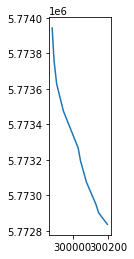

In [5]:
# load and display the shoreline
path_to_shoreline_mar=r'C:\my_packages\doc_data\test_data\shorelines\leo_shoreline_short.gpkg' # Marengo shoreline

shoreline=gpd.read_file(path_to_shoreline_mar)
shoreline.plot()

C:\conda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,tr_id,geometry,location
0,0,"LINESTRING (300166.471 5772833.267, 300206.279...",mar
1,1,"LINESTRING (300154.369 5772849.190, 300194.177...",mar
2,2,"LINESTRING (300142.267 5772865.113, 300182.075...",mar
3,3,"LINESTRING (300130.166 5772881.037, 300169.974...",mar
4,4,"LINESTRING (300119.411 5772904.944, 300165.639...",mar


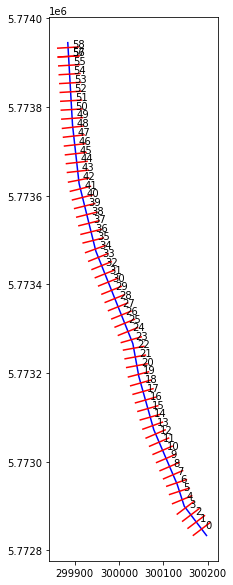

In [6]:
# create and display the transects (in red)

f,ax=plt.subplots(figsize=(10,10))  # Change figsize if you want bigger images
location='mar'  # insert the location code for this transect.

transects=create_transects(shoreline,
                           sampling_step=20, # alongshore spacing
                           tick_length=50, # transects length
                           location=location,crs=crs_dict_string[location],
                           side='both' # 'both':transect is centered at the interesction with the baseline
                          )

# Modify the figure by plotting shoreline, transects and transect IDs.
shoreline.plot(ax=ax,color='b')
transects.plot(ax=ax,color='r')

for x, y, label in zip(transects.geometry.centroid.x, transects.geometry.centroid.y, transects.tr_id):
    ax.annotate(label, xy=(x, y), xytext=(4, 1), textcoords="offset points")

transects.head()

The following cell saves transect to file and name it as:

>__locationCode_whateverYouWant.gpkg__

(example: __leo_transects.gpkg__)

and place it to a folder where you store all the transects for each location.

>__Note:__ If the saving throws an error "PLE_NotSupported in dataset leo_transects.gpkg does not support layer creation option ENCODING", the file should be created and valid anyway. Double-check by opening it in Qgis.

In [7]:
transects.to_file(filename=r'C:\my_packages\doc_data\transects\leo_transects.gpkg',driver='GPKG')

## Elevation and RGB data extraction

### Define the folders containing the datasets

First, let's define the paths to the folders containing the raster DSMs or ORTOs and the transects.

> __SUPPORTED FORMATS:__
>* Rasters: __geotiffs (.tif, .tiff)__
>* Transects: __geopackages (.gpkg).__
>
>__Transects filenames:__ when creating transects, save them with the location code as filename.

<img src="images/hill_ortho_profiles_cow.png" width="85%" />

In [5]:
# Set the path to the folders containing the DSMs (dirNameDSM) and the transect files (dirNameTrans)

dirNameDSM=r'C:\my_packages\sandpyper\tests\test_data\dsm_1m'

dirNameOrtho=r'C:\my_packages\sandpyper\tests\test_data\orthos_1m'

dirNameTrans=r'C:\my_packages\sandpyper\tests\test_data\transects'


###  Check cross-reference table and CRS matches

The EPSG codes in the raster and transect columns __must match__.

Please also check the dsm and date columns match transect file and dsm file paths.

In [6]:
check=cross_ref(dirNameDSM,dirNameTrans,print_info=True, loc_search_dict=loc_search_dict,list_loc_codes=loc_codes)
check

DSM from leo = 6

DSM from mar = 9


NUMBER OF DATASETS TO PROCESS: 15


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


,raw_date,filename_raster,crs_raster,filename_trs,crs_transect
location,,,,,
leo,20180606,C:\my_packages\sandpyper\tests\test_data\dsm_1...,32755,C:\my_packages\sandpyper\tests\test_data\trans...,epsg:32755
leo,20180713,C:\my_packages\sandpyper\tests\test_data\dsm_1...,32755,C:\my_packages\sandpyper\tests\test_data\trans...,epsg:32755
leo,20180920,C:\my_packages\sandpyper\tests\test_data\dsm_1...,32755,C:\my_packages\sandpyper\tests\test_data\trans...,epsg:32755
leo,20190211,C:\my_packages\sandpyper\tests\test_data\dsm_1...,32755,C:\my_packages\sandpyper\tests\test_data\trans...,epsg:32755
leo,20190328,C:\my_packages\sandpyper\tests\test_data\dsm_1...,32755,C:\my_packages\sandpyper\tests\test_data\trans...,epsg:32755
leo,20190731,C:\my_packages\sandpyper\tests\test_data\dsm_1...,32755,C:\my_packages\sandpyper\tests\test_data\trans...,epsg:32755
mar,20180601,C:\my_packages\sandpyper\tests\test_data\dsm_1...,32754,C:\my_packages\sandpyper\tests\test_data\trans...,epsg:32754
mar,20180621,C:\my_packages\sandpyper\tests\test_data\dsm_1...,32754,C:\my_packages\sandpyper\tests\test_data\trans...,epsg:32754
mar,20180727,C:\my_packages\sandpyper\tests\test_data\dsm_1...,32754,C:\my_packages\sandpyper\tests\test_data\trans...,epsg:32754


Nice! We are now ready to extract data from DSMs or ORTOs with the provided transect files.

### Extraction of profiles from folder

This is the cell where the automatic extraction gets processed.
The only parameter to set is the __sampling step__ variable, which indicates the __cross-shore sampling distance (m)__ that we want to use along our transects. Beware, although you could use a very small sampling distance (UAV datasets tend to be between few to 10 cm pixel size), file dimension will increase significantly!.

__Dealing with NaNs__

>NaNs might come from two different cases:
>1. extraction of points generated on transects falling __outside__ of the underlying raster extent
>2. points sampled from transect __inside__ the raster extent but containing NoData cells.
>
>Conveniently, the extraction profile function makes sure that if points fall outside the raster extent (case 1), those >elevations are assigned a default nan value, in the NumPy np.nan form.
>In case 2, however, the values extracted depends on the definition of NaNs of the source raster format.

In [7]:
%%time

## Parameters to specify

transect_folder=dirNameTrans
sampling_step=1


gdf_rgb=extract_from_folder(dataset_folder=dirNameOrtho,
                        transect_folder=transect_folder,
                        mode="ortho",sampling_step=sampling_step,
                        list_loc_codes=loc_codes,
                        add_xy=True)

gdf=extract_from_folder(dataset_folder=dirNameDSM,
                        transect_folder=transect_folder,
                        mode="dsm",sampling_step=sampling_step,
                        list_loc_codes=loc_codes,
                        add_xy=True)


  0%|          | 0/15 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Extraction succesfull
Number of points extracted:32805
Time for processing=49.164700508117676 seconds
First 10 rows are printed below
Number of points outside the raster extents: 27198
The extraction assigns NaN.
Number of points in NoData areas within the raster extents: 0
The extraction assigns NaN.


  0%|          | 0/15 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Extraction succesfull
Number of points extracted:32805
Time for processing=44.340404748916626 seconds
First 10 rows are printed below
Number of points outside the raster extents: 9066
The extraction assigns NaN.
Number of points in NoData areas within the raster extents: 250
The extraction assigns NaN.
Wall time: 1min 33s


In [12]:
gdf.head()

,distance,z,tr_id,raw_date,coordinates,location,survey_date,point_id,x,y
0,0.0,-0.004195,21,20190516,POINT (731646.904 5705523.469),mar,2019-05-16,61121091m2580400ar00,731646.903760,5.705523e+06
1,0.1,-0.004196,21,20190516,POINT (731646.821 5705523.525),mar,2019-05-16,61126091m2590410ar00,731646.821214,5.705524e+06
2,0.2,-0.004195,21,20190516,POINT (731646.739 5705523.582),mar,2019-05-16,61125091m2540920ar00,731646.738668,5.705524e+06
3,0.3,-0.004195,21,20190516,POINT (731646.656 5705523.638),mar,2019-05-16,61124091m2500430ar00,731646.656122,5.705524e+06
4,0.4,-0.004196,21,20190516,POINT (731646.574 5705523.695),mar,2019-05-16,61122091m2550840ar00,731646.573577,5.705524e+06


### GOOD!

save the Geodataframes (gdf and gdf_rgb) as a CSV file and head to the __SANDPYPER Labeling sand notebook__.

In [8]:
# Saving the files

gdf.to_csv(r"C:\my_packages\sandpyper\tests\test_outputs\gdf.csv",index=False)
gdf_rgb.to_csv(r"C:\my_packages\sandpyper\tests\test_outputs\gdf_rgb.csv",index=False)

___